# Regression Model for all links for Network Rate prediction
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq,fmin_slsqp, least_squares

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

#### Get AGIS endpoints (RSEs) and site names

In [2]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Collect all the links

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-10-01'  # yyyy-mm-dd
DELTA = 1
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = ['fts_*']
#for i in range(-1, DELTA+1):
#    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
#                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse","transferred_at","submitted_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']] not in data:
        data.append(rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']])
        count += 1
print('Reading',count, 'registers took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK'])

['fts_*']
Reading 9573 registers took 1497.8432257175446 seconds.


In [21]:
links = data
links.values[10]

array(['CERN-PROD_DATADISK', 'DESY-HH_DATADISK', 'CERN-PROD__DESY-HH',
       2088011, 1501850181.0, 1501850193.0, 1501850195.0, 12.0, 1044005.5,
       14.0, 562187.7420334595], dtype=object)

In [3]:
def get_data(src,dst):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = '2017-10-01'  # yyyy-mm-dd
    DELTA = 1
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = ['fts_*']
    indexes = ','.join(index_list)
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "src", "dst", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "src" : src }},
                    {"term" : { "dst" : dst }},                    
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([r['src_rse'],r['dst_rse'],rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    print('Reading', count,'registers took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['SRC','DST','LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    return data

def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model

def get_model(link, data, show=False):
    #cut = data.where(data.LINK == link).dropna()
    cut = data
    cut = cut.where(cut.SIZE > 0).dropna()
    cut = cut.where(cut.N_RATE > 0).dropna()
    if len(cut) < 20:
        return link[0],-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf
    vars = [cut.N_RATE.mean(), 1., 100.0]
    try:
        out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    except ValueError:
        print('Problem on link:', link, '. trying another start')
        try:
            first = cut[cut.SIZE < np.median(cut.SIZE)]
            p1 = np.polyfit(first.SIZE, first.N_RATE,1)
            p1 = np.poly1d(p1)
            secnd = cut[cut.SIZE > np.median(cut.SIZE)]
            p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
            p2 = np.poly1d(p2)
            oini=max(0.01,1/p1.coeffs[0])
            dini=max(0.01,1/p2.coeffs[0])
            vars = [cut.N_RATE.mean(), oini, dini]
            out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
        except ValueError:
            cut = data.sample(int(len(data)*0.5))
            while len(cut) > 20:
                vars = [cut.N_RATE.mean(), 1., 100.0]
                try:
                    out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
                    break
                except ValueError:
                    print('Couldn\'t solve problem for', link,'.  Retrying...')
                    cut = cut.sample(int(len(cut)*0.5))
                    continue
            if len(cut) <= 20:
                print('Couldn\'t solve problem for', link)
                return link[0], -np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,
    rate = out.x[0]
    overhead = out.x[1]
    diskrw = out.x[2]
    #print(link,out)data
    data['N_PRED'] = data.SIZE/((data.SIZE/rate)+overhead)
    data['N_PRED'][data['N_PRED']>diskrw]=diskrw
    cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    datalen = len(cut)
    if show:
        cut = data.set_index(pd.to_datetime(data.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        plt.title('NETWORK rates for %s'%link)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Link Rate in MiB/s')
        plt.ylabel('Transfer rate in MiB/s')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show() 
    return link,r2score, rmse, datalen, rate,overhead,diskrw

In [ ]:
link_stats = []
for link in links.values:
    src,dst = link[0].split('__')
    #link = links.values[10][0]
    #src,dst = 'CERN-PROD','BNL-ATLAS'
    print('')
    print(src,'-->',dst)
    data = get_data(src,dst)
    #print(len(data) > 0)
    link_stats.append(get_model(link,data,show=False))

In [ ]:
df = pd.DataFrame(link_stats, columns=['LINK','R2','RMSE', 'DATALEN', 'RATE','OVERHEAD', 'DISKRW' ])

In [ ]:
df

In [7]:
data = get_data('BNL-ATLAS','MWT2')

Reading 103695 registers took 15.275689840316772 seconds.


In [9]:
data.to_csv('bnl2mwt2.csv')

Reading 0 registers took 0.08748984336853027 seconds.


AttributeError: 'DataFrame' object has no attribute 'N_PRED'

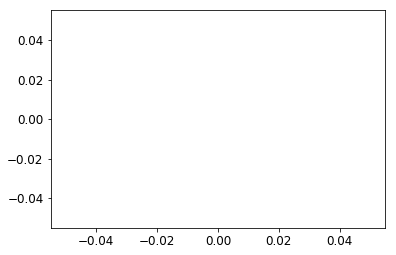

In [23]:
link = 'CERN-PROD__BNL-ATLAS'
link = 'WT2__UKI-SCOTGRID-DURHAM'
link = 'CERN-PROD__UNI-FREIBURG'
link = 'TOKYO-LCG2__RO-02-NIPNE'
link = 'CERN-PROD__DESY-HH'
link = 'INFN-ROMA2__mainzgrid'
data = get_data(link.split('__')[0],link.split('__')[1])
out = get_model(link.replace('__','-->'),data, show=True)
plt.plot(data.SIZE/2**20,data.N_RATE/(1024*1024),'.')
plt.plot(data.SIZE/2**20,data.N_PRED/(1024*1024),'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MiB')
plt.ylabel('MiB/s')
plt.title('Network rate for %s'%link.replace('__','-->'))
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
print(out)
plt.show()

In [ ]:
def test_model(link, data, model=model, overh_init=0.1, diskrw_init=100., show=False):
    cut = data.where(data.LINK == link).dropna()
    cut.N_RATE[cut.N_RATE == np.inf] = np.nan
    cut = cut.dropna()
    #cut = cut.where(cut.SIZE > 0).dropna()
    #cut = cut.where(cut.N_RATE > 0).dropna()
    if link not in model.LINK.values:
        print('WARNING: no model found for', link,maxindex)
        cut['N_PRED'] = [-np.inf]*len(cut)
    else:
        rate = model[model.LINK == link].RATE.values[0]
        overhead = model[model.LINK == link].OVERHEAD.values[0]
        diskrw = model[model.LINK == link].DISKRW.values[0]
        cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
        cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    
    #vars = [cut.N_RATE.mean(), overh_init, diskrw_init]
    #vars = [cut.N_RATE.mean(), 0.1, 100.]
    #out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    #out = leastsq(objective, vars, args=(cut.SIZE, cut.N_RATE))
    #rate = out.x[0]
    #overhead = out.x[1]
    #diskrw = out.x[2] 
    #print(link,out)
    #cut['N_PRED2'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    #cut['N_PRED2'][cut['N_PRED2']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    #try:
    #    r2score2 = r2(cut.N_RATE,cut.N_PRED2)
    #    rmse2 = np.sqrt(mse(cut.N_RATE,cut.N_PRED2))
    #except ValueError:
    #    r2score2 = -np.Inf
    #    rmse2 = np.Inf
    datalen = len(cut)
    if show:
        cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        #plt.plot(cut.SIZE/(1024*1024), cut.N_PRED2/(1024*1024),'.', label='pred new')
        plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Link Rate in MiB/s')
        plt.xlabel('Transfer size MiB')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show()
    return r2score, rmse, datalen, rate, overhead, diskrw#, r2score2, rmse2

In [ ]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
link = 'CERN-PROD__BNL-ATLAS'
#link = 'BNL-ATLAS__CERN-PROD'
#link = 'RAL-LCG2__CSCS-LCG2'
#link = 'FZK-LCG2__SWT2_CPB'
#link = 'SARA-MATRIX__ru-PNPI'
#link = 'BNL-ATLAS__CA-MCGILL-CLUMEQ-T2'
#link = 'Taiwan-LCG2__SiGNET'
#link =  'UNI-FREIBURG__BNL-ATLAS'
#link = 'UKI-SCOTGRID-GLASGOW__Taiwan-LCG2'
#link = 'WT2__BNL-ATLAS'
#link =  'RRC-KI-T1__RAL-LCG2'
#link = 'IFIC-LCG2__INFN-T1'
#link = 'RAL-LCG2__CSCS-LCG2'
cut = data.where(data.LINK == link).dropna()
cut.N_RATE[cut.N_RATE == np.inf] = cut.SIZE
plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()
plt.hist(cut.N_RATE,bins=100)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
first = cut[cut.SIZE < 10**6]
p1 = np.polyfit(first.SIZE, first.N_RATE,1)
p1 = np.poly1d(p1)
secnd = cut[cut.SIZE > 10**7]
p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
p2 = np.poly1d(p2)
oini=max(0.01,1/p1.coeffs[0])
dini=max(0.01,1/p2.coeffs[0])
print('Initialization: overhead=%f  diskrw=%f'%(oini, dini))
r_2,rmse,datalen, rate,over,disk= test_model(link, data,model2,overh_init=oini,diskrw_init=dini, show=True)
print('r2:   ', r_2)
print('rmse: ', rmse/(1024*1024))
print('rate: ', rate/(1024*1024))
print('overh:', over)
print('disk: ', disk/(1024*1024))
#print('r2.2: ', r_22)
#print('rmse2:', rmse2/(1024*1024))

In [ ]:
d = {}
for v in cut.itertuples():
    if v.SRC+'__'+v.DST not in d.keys():
        d[v.SRC+'__'+v.DST] = []
    d[v.SRC+'__'+v.DST].append([v.SIZE, v.N_RATE])

for k in d:
    d[k] = np.array(d[k]).T


In [ ]:
for k in d:
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
for k in d:
    x = '%0.2f, %0.2f, %d, %s' %(d[k][1].mean()/(1024*1024),d[k][1].std()/(1024*1024), len(d[k][0]), k)
    print (x)

In [ ]:
for k in d:
    #plt.hist(d[k][1]/(1024*1024),bins=100, alpha=0.9)
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
    plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Link Rate in MiB/s')
    plt.xlabel('Transfer size MiB')
    fig = plt.gcf()
    fig.set_size_inches(17, 8)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
model2.corr()

In [ ]:
plt.plot(model2.RATE[model2.RATE > -np.inf]/(1024*1024),
         model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),
         #model2.OVERHEAD[model2.OVERHEAD > -np.inf],
         '.', alpha=0.9)
#plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rate in MiB/s')
plt.ylabel('Disk r/w limit MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist(model2.RATE[model2.RATE > -np.inf][model2.RATE < 10**9]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('MiB/s')
#lt.xlim((0,100))
plt.title('RATE')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.OVERHEAD[model2.OVERHEAD > -np.inf],bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('OVERHEAD')
plt.xlabel('seconds')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('DISKRW')
plt.xlabel('MiB/s')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()